### Import data

In [35]:
import pickle
import numpy as np

def read_data(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    data = x.load()
    return data

files = []
for n in range(1, 33):
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)

labels = []
data = []
for i in files:
    filepath = "archive/data_preprocessed_python/s" + i + ".dat"
    d = read_data(filepath)
    labels.append(d['labels'])
    data.append(d['data'])



#### Reshape data

In [36]:

labels = np.array(labels)
data = np.array(data)
print(labels.shape)
print(data.shape)
labels = labels.reshape(1280, 4)
data = data.reshape(1280, 40, 8064)
print(labels.shape)
print(data.shape)
eeg_data = data[:,:32,:]
print(eeg_data.shape)


(32, 40, 4)
(32, 40, 40, 8064)
(1280, 4)
(1280, 40, 8064)
(1280, 32, 8064)


#### Visualize data

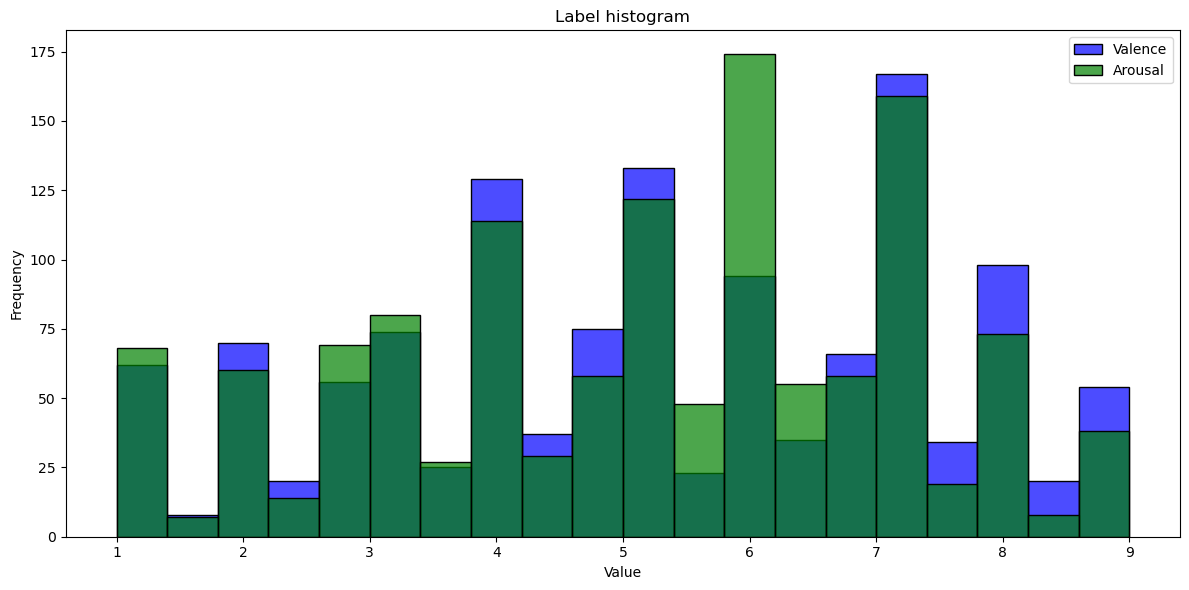

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot overlapping histograms for the first and second columns of labels
plt.figure(figsize=(12, 6))

sns.histplot(labels[:, 0], bins=20, color='blue', alpha=0.7, label='Valence')
sns.histplot(labels[:, 1], bins=20, color='green', alpha=0.7, label='Arousal')

plt.title('Label histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


#### Compute Power Spectral Density of brain signals for each brain wave band

In [56]:
from scipy.signal import welch
from scipy.integrate import simps
def bandpower(data, sf, band):
    band = np.asarray(band)
    low, high = band
    nperseg = (2 / low) * sf
    freqs, psd = welch(data, sf, nperseg=nperseg)
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    bp = simps(psd[idx_band], dx=freq_res)
    return bp

def get_band_power(people, channel, band):
    bd = (0,0)
    if (band == "delta"):
        bd = (0.5,4)
    if (band == "theta"):
        bd = (4,8)
    elif (band == "alpha"):
        bd = (8,12)
    elif (band == "beta"):
        bd = (12,30)
    elif (band == "gamma"):
        bd = (30,64)
    return bandpower(eeg_data[people,channel], 128, bd)

eeg_band = []
for i in range (len(eeg_data)):
    for j in range (len(eeg_data[0])):
        eeg_band.append(get_band_power(i,j,"delta"))
        eeg_band.append(get_band_power(i,j,"theta"))
        eeg_band.append(get_band_power(i,j,"alpha"))
        eeg_band.append(get_band_power(i,j,"beta"))
        eeg_band.append(get_band_power(i,j,"gamma"))


eeg_band = np.array(eeg_band)
eeg_band = eeg_band.reshape((1280,160)) # 5×32 = 160; 5 bands per electrode
print(eeg_band.shape)
np.save("eeg_band.npy", eeg_band)
eeg_band = np.load("eeg_band.npy")
print(eeg_band.shape)

(1280, 160)
(1280, 160)


In [57]:
import pandas as pd
pd.DataFrame(eeg_band).head(10)

,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
0,0.030791,3.966387,3.362791,5.815234,1.216603,0.067184,5.102688,3.944452,6.646149,1.261336,...,0.091025,6.766592,6.189954,7.055265,1.177492,0.065847,5.434120,5.369596,6.286556,0.987916
1,0.086600,5.171664,4.159797,6.395374,1.450174,0.134854,7.009709,4.826470,7.266016,1.318514,...,0.221600,10.031310,7.715087,7.725304,1.253575,0.110520,7.958460,6.850178,6.795912,1.152470
2,0.057484,4.839268,4.294426,6.721424,1.541999,0.089844,6.321618,5.004187,8.149888,1.660937,...,0.137920,9.238961,9.179372,9.283133,1.479029,0.073230,6.864887,8.209320,8.429777,1.410791
3,0.053079,4.442888,3.519818,5.380133,1.280744,0.059321,6.709155,4.250171,6.090829,1.208452,...,0.086876,8.802466,6.922430,6.950315,1.132223,0.050054,6.850906,6.541218,6.753938,1.026295
4,0.038066,2.698928,2.770151,4.911636,1.076200,0.054365,3.034321,2.933423,5.472712,1.120326,...,0.050368,3.678479,5.225959,6.270482,1.036078,0.058468,3.681268,5.195625,6.161676,0.946582
5,0.051739,4.024860,3.535367,5.426490,1.357932,0.082481,4.900829,3.852156,6.035693,1.174744,...,0.106770,7.521480,7.106088,7.050821,1.291767,0.070789,6.610349,6.224046,6.247701,1.124890
6,0.072726,4.524433,4.117581,5.698607,1.241507,0.095898,6.056792,4.746292,7.080272,1.584222,...,0.173744,9.016845,8.124075,8.281151,1.269174,0.084738,5.524867,6.822795,7.488367,1.131017
7,0.053950,6.224641,5.034346,6.856175,1.567620,0.080708,8.286740,6.205477,8.272224,1.442914,...,0.130589,10.325636,10.840115,9.648808,1.569249,0.077480,8.362805,10.041464,9.171436,1.721038
8,0.052016,6.404616,5.135986,7.506420,1.755587,0.095538,9.482683,6.235595,8.842913,1.499615,...,0.184748,13.525893,9.954437,9.419640,1.598435,0.066551,9.477365,8.160465,8.362228,1.474454
9,0.060121,4.157208,4.034130,6.073305,1.330574,0.083487,5.091712,4.395577,7.080776,1.307593,...,0.098387,7.202638,7.129745,8.121126,1.566362,0.044774,5.193759,6.046838,7.244295,1.712771


#### Encode labels

In [58]:
label_name = ["valence","arousal"]
labels_valence = []
labels_arousal = []

#9 classes
#labels_valence = ["LOW" if la[0] < 3 else "MEDIUM" if la[0] < 6 else "HIGH" for la in labels] 
#labels_arousal = ["LOW" if la[1] < 3 else "MEDIUM" if la[1] < 6 else "HIGH" for la in labels]

#4 classes
labels_valence = ["LOW" if lab[0] < 5 else "HIGH" for lab in labels]
labels_arousal = ["LOW" if lab[1] < 5 else "HIGH" for lab in labels]

combined_labels = np.array([labels_valence[i] + '_' + labels_arousal[i] for i in range(len(labels_valence))]).reshape(-1,1)


from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(combined_labels)
enc.categories_
yData_enc = enc.transform(combined_labels).reshape(-1)

num_categories = len(np.unique(yData_enc))
num_categories

4

In [59]:
pd.DataFrame({'Valence': np.array(labels_valence).reshape(-1), 'Arousal': np.array(labels_arousal).reshape(-1),'combined_labels': combined_labels.reshape(-1), 'yData_enc': yData_enc.reshape(-1)}).head(10)

,Valence,Arousal,combined_labels,yData_enc
0,HIGH,HIGH,HIGH_HIGH,0.0
1,HIGH,HIGH,HIGH_HIGH,0.0
2,HIGH,HIGH,HIGH_HIGH,0.0
3,LOW,HIGH,LOW_HIGH,2.0
4,HIGH,LOW,HIGH_LOW,1.0
5,HIGH,LOW,HIGH_LOW,1.0
6,HIGH,LOW,HIGH_LOW,1.0
7,HIGH,LOW,HIGH_LOW,1.0
8,LOW,LOW,LOW_LOW,3.0
9,LOW,LOW,LOW_LOW,3.0


#### Extract polynomial features and select the ones that explain variance (PCA) - Include this in the report ? - Generate xData1

In [83]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

xData_eeg_band = eeg_band

poly = preprocessing.PolynomialFeatures(degree=2)
pca = PCA(n_components=500)

xData_eeg_band = poly.fit_transform(xData_eeg_band)
xData_eeg_band=pca.fit_transform(xData_eeg_band)

xData_eeg_band = preprocessing.scale(xData_eeg_band)
xData_eeg_band.shape

(1280, 500)

#### K-nearest neighbors classifier

n_neighbors: 1, train_score: 1.0000, test_score: 0.2891
n_neighbors: 2, train_score: 0.6992, test_score: 0.3320
n_neighbors: 3, train_score: 0.6182, test_score: 0.3438
n_neighbors: 4, train_score: 0.5869, test_score: 0.3398
n_neighbors: 5, train_score: 0.5645, test_score: 0.3281
n_neighbors: 6, train_score: 0.5439, test_score: 0.3477
n_neighbors: 7, train_score: 0.5322, test_score: 0.3633
n_neighbors: 8, train_score: 0.5205, test_score: 0.3477
n_neighbors: 9, train_score: 0.5059, test_score: 0.3320
n_neighbors: 10, train_score: 0.4863, test_score: 0.3359
n_neighbors: 11, train_score: 0.4912, test_score: 0.3555
n_neighbors: 12, train_score: 0.4697, test_score: 0.3281
n_neighbors: 13, train_score: 0.4629, test_score: 0.3555
n_neighbors: 14, train_score: 0.4463, test_score: 0.3594
n_neighbors: 15, train_score: 0.4453, test_score: 0.3594
n_neighbors: 16, train_score: 0.4414, test_score: 0.3711
n_neighbors: 17, train_score: 0.4453, test_score: 0.3633
n_neighbors: 18, train_score: 0.4336, te

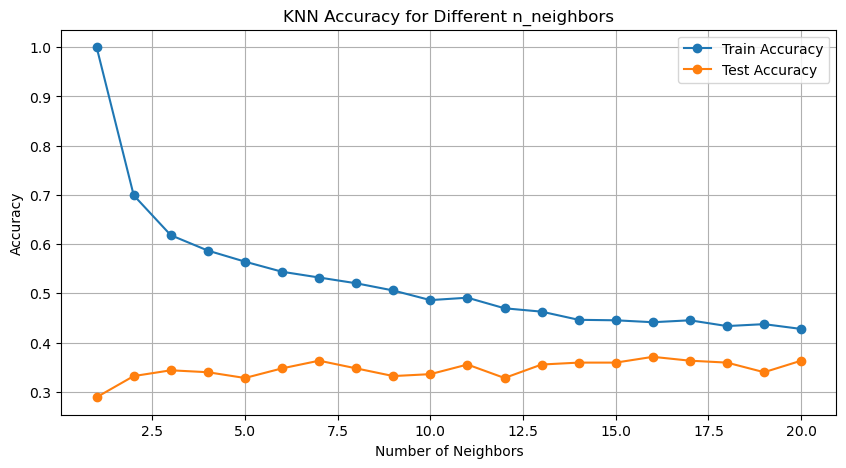

KNeighborsClassifier(n_neighbors=16)

In [84]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(xData_eeg_band, yData_enc, test_size=0.2, random_state=42)

# Loop over different values of n_neighbors
neighbors = range(1, 21)
train_scores = []
test_scores = []

for n in neighbors:
    modelKNN = KNeighborsClassifier(n_neighbors=n)
    modelKNN.fit(X_train, y_train)
    
    train_score = modelKNN.score(X_train, y_train)
    test_score = modelKNN.score(X_test, y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print(f"n_neighbors: {n}, train_score: {train_score:.4f}, test_score: {test_score:.4f}")

print("Best number of neighbors: ",neighbors[np.argmax(test_scores)])

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(neighbors, train_scores, label='Train Accuracy', marker='o')
plt.plot(neighbors, test_scores, label='Test Accuracy', marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for Different n_neighbors')
plt.legend()
plt.grid(True)
plt.show()


modelKNN = KNeighborsClassifier(n_neighbors = neighbors[np.argmax(test_scores)])
modelKNN.fit(X_train, y_train)
    

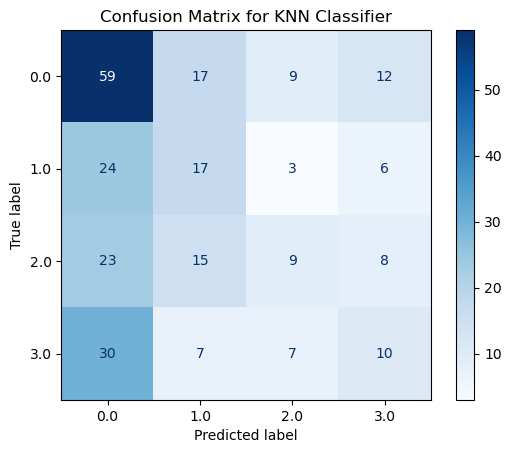

              precision    recall  f1-score   support

   HIGH_HIGH       0.43      0.61      0.51        97
    HIGH_LOW       0.30      0.34      0.32        50
    LOW_HIGH       0.32      0.16      0.22        55
     LOW_LOW       0.28      0.19      0.22        54

    accuracy                           0.37       256
   macro avg       0.33      0.32      0.32       256
weighted avg       0.35      0.37      0.35       256



In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Predict the labels for the test set
y_pred = modelKNN.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier')
plt.show()

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=enc.categories_[0])
print(report)

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

# Define the neural network model
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Classifier, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Second fully connected layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Third fully connected layer
        self.fc3 = nn.Linear(hidden_size, hidden_size)

        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)

        # Output layer
        self.fcFinal = nn.Linear(hidden_size, num_classes)

        # Activations, Dropout, and Batch Normalization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)  # Dropout with 30% probability
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        # Forward pass with batch normalization and dropout
        out = self.fc1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc3(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc4(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)


        out = self.fc5(out)
        out = self.relu(out)

        out = self.fcFinal(out)
        return out
    


    import torch
import torch.nn as nn
import torch.optim as optim

class EEGClassifierCNN(nn.Module):
    def __init__(self,num_classes):
        super(EEGClassifierCNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Third convolutional layer
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Fully connected layer
        self.fc1 = nn.Linear(256 * (8064 // 8), 512)  # Adjust to account for pooling
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)  # 9 classes
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


# Function to calculate accuracy
def calculate_accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)  # Get index of the max log-probability
    correct = (predicted == targets).sum().item()
    accuracy = correct / targets.size(0)
    return accuracy




In [88]:

# Model parameters
input_size = len(xData_eeg_band[0])  # Number of input features (depends on your data)
hidden_size = 128  # Number of neurons in the hidden layers
num_classes = num_categories  # Number of output classes


# Hyperparameters
learning_rate = 0.002
num_epochs = 100
batch_size = 32

# Convert to PyTorch tensors
xData_tensor = torch.tensor(xData_eeg_band, dtype=torch.float32)
yData_tensor = torch.tensor(yData_enc, dtype=torch.long)  # For classification, labels should be long

# Create train and validation datasets
X_train, X_val, y_train, y_val = train_test_split(xData_tensor, yData_tensor, test_size=0.2, random_state=42)

# Initialize model, loss function, and optimizer
#model = EEGConformer(input_size, num_classes)
modelNN = Classifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(modelNN.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    modelNN.train()
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i + batch_size]
        batch_y = y_train[i:i + batch_size]

        # Forward pass
        outputs = modelNN(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    with torch.no_grad():
        modelNN.eval()
        val_outputs = modelNN(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_accuracy = calculate_accuracy(val_outputs, y_val)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [eval{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')

# Save the model
torch.save(modelNN.state_dict(), 'classifier_model.pth')


Epoch [eval10/100], Loss: 0.4286, Val Loss: 1.8199, Val Accuracy: 0.3633
Epoch [eval20/100], Loss: 0.1151, Val Loss: 2.3510, Val Accuracy: 0.3984
Epoch [eval30/100], Loss: 0.1655, Val Loss: 2.7528, Val Accuracy: 0.3906
Epoch [eval40/100], Loss: 0.2370, Val Loss: 2.9417, Val Accuracy: 0.3789
Epoch [eval50/100], Loss: 0.1122, Val Loss: 3.0769, Val Accuracy: 0.3672
Epoch [eval60/100], Loss: 0.0990, Val Loss: 3.4205, Val Accuracy: 0.3867
Epoch [eval70/100], Loss: 0.0393, Val Loss: 3.1044, Val Accuracy: 0.3672
Epoch [eval80/100], Loss: 0.0621, Val Loss: 3.1738, Val Accuracy: 0.3633
Epoch [eval90/100], Loss: 0.0780, Val Loss: 3.2135, Val Accuracy: 0.4023
Epoch [eval100/100], Loss: 0.0520, Val Loss: 3.1638, Val Accuracy: 0.3828


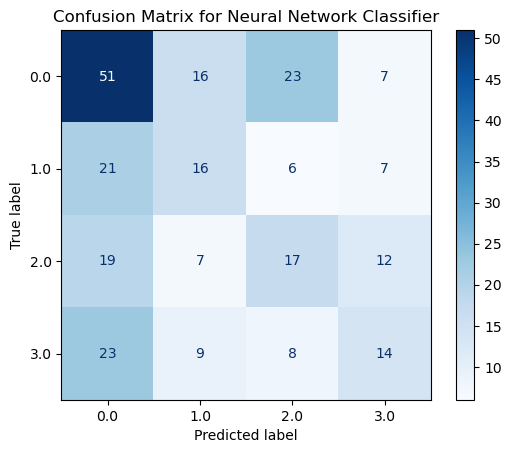

              precision    recall  f1-score   support

   HIGH_HIGH       0.45      0.53      0.48        97
    HIGH_LOW       0.33      0.32      0.33        50
    LOW_HIGH       0.31      0.31      0.31        55
     LOW_LOW       0.35      0.26      0.30        54

    accuracy                           0.38       256
   macro avg       0.36      0.35      0.35       256
weighted avg       0.38      0.38      0.38       256



In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Predict the labels for the test set using the neural network model
modelNN.eval()
with torch.no_grad():
    y_pred_tensor = modelNN(torch.tensor(X_test, dtype=torch.float32))
    _, y_pred = torch.max(y_pred_tensor, 1)
    y_pred = y_pred.numpy()

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Neural Network Classifier')
plt.show()

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=enc.categories_[0])
print(report)

#### Convolutional NN

In [90]:
# Instantiate the model
modelCNN = EEGClassifierCNN(num_categories)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelCNN.parameters(), lr=0.001)


# Hyperparameters
learning_rate = 0.002
num_epochs = 5
batch_size = 32


xData = eeg_data

# Convert to PyTorch tensors
xData_tensor = torch.tensor(xData, dtype=torch.float32)
yData_tensor = torch.tensor(yData_enc, dtype=torch.long)  # For classification, labels should be long

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(xData_tensor, yData_tensor, test_size=0.2, random_state=42)


# Training loop
for epoch in range(num_epochs):
    modelCNN.train()
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i + batch_size]
        batch_y = y_train[i:i + batch_size]

        # Forward pass
        outputs = modelCNN(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    with torch.no_grad():
        modelCNN.eval()
        val_outputs = modelCNN(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_accuracy = calculate_accuracy(val_outputs, y_val)
    
    print(f'Epoch [eval{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')

# Save the model
torch.save(modelCNN.state_dict(), 'classifier_model.pth')

Epoch [eval1/5], Loss: 9.9753, Val Loss: 3.7328, Val Accuracy: 0.1875
Epoch [eval2/5], Loss: 1.3502, Val Loss: 1.6669, Val Accuracy: 0.3633
Epoch [eval3/5], Loss: 1.3099, Val Loss: 1.3899, Val Accuracy: 0.1836
Epoch [eval4/5], Loss: 1.3475, Val Loss: 1.6325, Val Accuracy: 0.3711
Epoch [eval5/5], Loss: 1.2386, Val Loss: 1.5393, Val Accuracy: 0.3750


C:\Users\josebencao9\AppData\Local\Temp\ipykernel_24232\2754628215.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_tensor = modelCNN(torch.tensor(X_val, dtype=torch.float32))


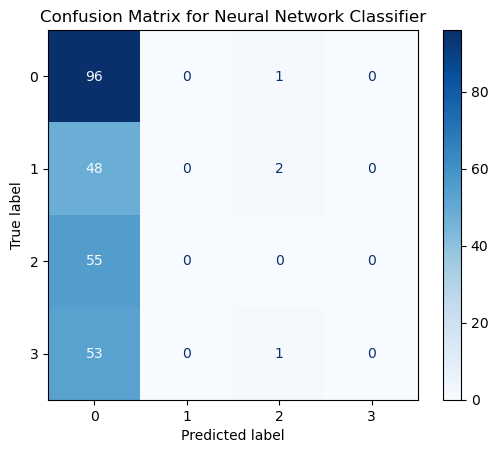

              precision    recall  f1-score   support

   HIGH_HIGH       0.38      0.99      0.55        97
    HIGH_LOW       0.00      0.00      0.00        50
    LOW_HIGH       0.00      0.00      0.00        55
     LOW_LOW       0.00      0.00      0.00        54

    accuracy                           0.38       256
   macro avg       0.10      0.25      0.14       256
weighted avg       0.14      0.38      0.21       256



c:\Users\josebencao9\miniconda3\envs\faip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\josebencao9\miniconda3\envs\faip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\josebencao9\miniconda3\envs\faip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


# Predict the labels for the test set using the neural network model
modelCNN.eval()
with torch.no_grad():
    y_pred_tensor = modelCNN(torch.tensor(X_val, dtype=torch.float32))
    _, y_pred = torch.max(y_pred_tensor, 1)
    y_pred = y_pred.numpy()

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_val))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Neural Network Classifier')
plt.show()

# Generate a classification report
report = classification_report(y_val, y_pred, target_names=enc.categories_[0])
print(report)

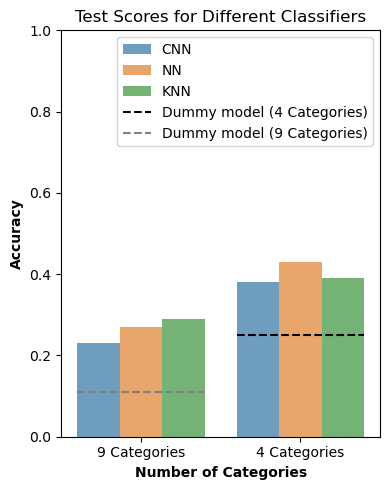

In [101]:
# Define the number of categories
categories = ['4 Categories', '9 Categories']

# Define the test scores for KNN, NN, and CNN
test_scores_KNN = [0.39, 0.29]  # 4 categories, 9 categories
test_scores_NN = [0.43, 0.27]    # 4 categories, 9 categories
test_scores_CNN = [0.38, 0.23]   # 4 categories, 9 categories

# Create a DataFrame for seaborn
data = pd.DataFrame({
    'Categories': categories * 3,
    'Accuracy': test_scores_KNN + test_scores_NN + test_scores_CNN,
    'Classifier': ['KNN'] * len(categories) + ['NN'] * len(categories) + ['CNN'] * len(categories)
})

# Sort the DataFrame by Accuracy
data = data.sort_values(by='Accuracy')

# Create the plot
plt.figure(figsize=(4, 5))
sns.barplot(x='Categories', y='Accuracy', hue='Classifier', data=data, alpha=0.7, dodge=True)

# Add dashed lines constrained to the blocks
plt.axhline(1/4, color='black', linestyle='--', label='Dummy model (4 Categories)', xmin=0.55, xmax=0.95)
plt.axhline(1/9, color='grey', linestyle='--', label='Dummy model (9 Categories)', xmin=0.05, xmax=0.45)

# Add labels and title
plt.xlabel('Number of Categories', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Test Scores for Different Classifiers')
plt.ylim(0, 1)

# Show the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


### How to explain the results?

#### Test model 

In [ ]:
# Model in evaluation mode
sampleIDX = 0

# Get the first sample from the testing set
sample_X = X_test[sampleIDX].reshape(1, -1)
sample_y = y_test[sampleIDX]

# Test the KNN model
knn_predicted = modelKNN.predict(sample_X)   

modelNN.eval()
with torch.no_grad():
    # Test the neural network model
    nn_predicted_tensor = modelNN(torch.tensor(sample_X, dtype=torch.float32))
    _, nn_predicted = torch.max(nn_predicted_tensor, 1)
    nn_predicted = nn_predicted.numpy()



sample_X = X_val[sampleIDX]
sample_y = y_val[sampleIDX]

modelCNN.eval()
with torch.no_grad():
    # Test the CNN model
    cnn_predicted_tensor = modelCNN(torch.tensor(sample_X, dtype=torch.float32))
    _, cnn_predicted = torch.max(cnn_predicted_tensor, 1)
    cnn_predicted = cnn_predicted.numpy()



# Print the actual and predicted labels
print(f'Actual label: {enc.inverse_transform(sample_y.reshape(1,-1))}')
print(f'Neural Network Predicted label: {enc.inverse_transform(nn_predicted.reshape(1,-1))}')
print(f'Convolutional Neural Network Predicted label: {enc.inverse_transform(cnn_predicted.reshape(1,-1))}')
print(f'K Nearest Neighbors Predicted label: {enc.inverse_transform(knn_predicted.reshape(1,-1))}')